Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import surprise
from surprise import PredictionImpossible
from surprise import Dataset, Reader
from surprise import SVDpp  
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

Loading data

The dataset is divided into three files: recommendations, games, and metadata. We will only use the recommendations and the games data

In [2]:
recommendations_filepath = "./data/recommendations.csv"
games_filepath = "./data/games.csv"

rec_data = pd.read_csv(recommendations_filepath)
games_data = pd.read_csv(games_filepath)

In [3]:
rec_data.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [4]:
games_data.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


Data explorataion

<Axes: xlabel='hours', ylabel='count'>

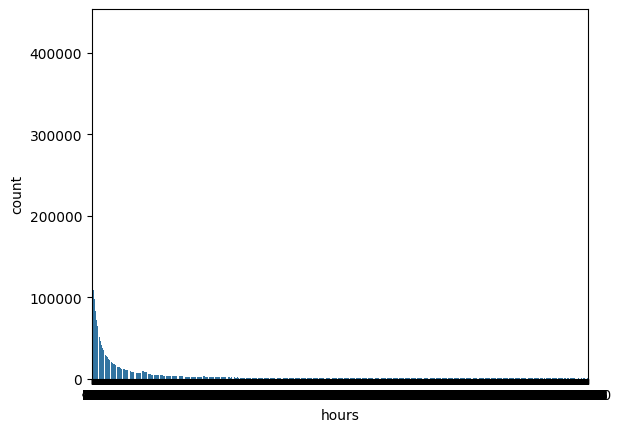

In [5]:
sns.barplot(x=rec_data.hours.value_counts().index, y=rec_data.hours.value_counts())

Lots of users who have zero hours in the game

<Axes: xlabel='is_recommended', ylabel='count'>

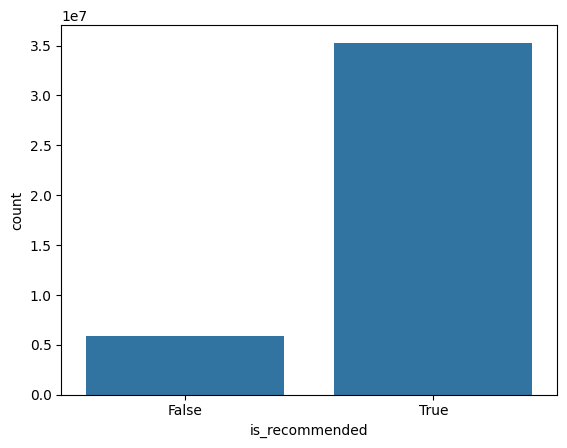

In [6]:
sns.barplot(x=rec_data.is_recommended.value_counts().index, y=rec_data.is_recommended.value_counts())

Because the dataset is large we will filter it save time and resources and avoid running out of memory

In [7]:
rec_data = rec_data.drop(columns = ['date','review_id', 'funny'])
games_data = games_data.drop(columns=['date_release', 'win', 'mac', 'linux', 'rating', 'price_original', 'discount' , 'steam_deck' ])

In [8]:
rec_data = rec_data[rec_data['hours'] >= 20]
rec_data = rec_data[rec_data['helpful'] >= 5]

In [9]:
rec_df = pd.merge(rec_data,games_data, on='app_id')
rec_df = rec_df.loc[~((rec_df['positive_ratio']<=40) | (rec_df['price_final']>=70.0))]
rec_df.head()

del rec_data

In [10]:
rec_df.head(5)

,app_id,helpful,is_recommended,hours,user_id,title,positive_ratio,user_reviews,price_final
0,570940,348,False,73.3,5136277,DARK SOULS™: REMASTERED,89,55356,20.0
1,570940,103,True,54.5,11045115,DARK SOULS™: REMASTERED,89,55356,20.0
2,570940,5,True,49.0,6661639,DARK SOULS™: REMASTERED,89,55356,20.0
3,570940,1502,False,62.7,11502164,DARK SOULS™: REMASTERED,89,55356,20.0
4,570940,170,True,35.3,8996571,DARK SOULS™: REMASTERED,89,55356,20.0


We now build our Matrix factorization model using the surprise library. This model uses Stochastic gradient descent to estimate the missing data

In [11]:
class MF(surprise.AlgoBase):

    def __init__(self, learning_rate, n_epochs, n_factors):
        
        self.lr = learning_rate  # learning rate for SGD
        self.n_epochs = n_epochs  # number of iterations of SGD
        self.n_factors = n_factors  # number of factors
        
    def fit(self, trainset):        
        print('Fitting data with SGD...')
        # Randomly initialize the user and item factors.
        p = np.random.normal(0, .1, (trainset.n_users, self.n_factors))
        q = np.random.normal(0, .1, (trainset.n_items, self.n_factors))
        
        # SGD procedure
        for _ in range(self.n_epochs):
            for u, i, r_ui in trainset.all_ratings():
                err = r_ui - np.dot(p[u], q[i])
                # Update vectors p_u and q_i
                p[u] += self.lr * err * q[i]
                q[i] += self.lr * err * p[u]
        
        self.p, self.q = p, q
        self.trainset = trainset
        
    def estimate(self, u, i):
        # return scalar product between p_u and q_i if user and item are known,
        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            return np.dot(self.p[u], self.q[i])
        else:
            # else return self.trainset.global_mean which us average of all ratings
            raise PredictionImpossible('User and item are unknown.')
            

We'll run the model through cross-validation to compare the RMSE and MAE metrics and see how they work with this dataset. For this recommendation system we are going to playtime as our rating and estimate the play hours for the games that user havent tried. The play hours have been normalized between 0 to 1 for better processing.

In [12]:
# rec_df = rec_df[rec_df['is_recommended'] == True]  #gave best rsme but ignores `negetively rated items`

# rec_df['isrec'] = 1
# rec_df['isrec'] = np.where(rec_df['is_recommended'] == False, rec_df['isrec']==0, rec_df['isrec']) # .5 rsme

rec_df['hours_norm'] = (rec_df['hours'] - rec_df['hours'].min())/(rec_df['hours'].max()-rec_df['hours'].min()) 
rec_df.head()

,app_id,helpful,is_recommended,hours,user_id,title,positive_ratio,user_reviews,price_final,hours_norm
0,570940,348,False,73.3,5136277,DARK SOULS™: REMASTERED,89,55356,20.0,0.054388
1,570940,103,True,54.5,11045115,DARK SOULS™: REMASTERED,89,55356,20.0,0.035204
2,570940,5,True,49.0,6661639,DARK SOULS™: REMASTERED,89,55356,20.0,0.029592
3,570940,1502,False,62.7,11502164,DARK SOULS™: REMASTERED,89,55356,20.0,0.043571
4,570940,170,True,35.3,8996571,DARK SOULS™: REMASTERED,89,55356,20.0,0.015612


We will now check the accuracy of the model by running it through 5 fold cross validation and obtain the root mean square error or RSME.

In [13]:
reader = Reader(rating_scale=(0.0, 1.0), skip_lines=1)
data = Dataset.load_from_df(rec_df[['user_id', 'app_id', 'hours_norm']], reader)
algo = MF(learning_rate=.01, n_epochs=10, n_factors=10)
cross_validate(algo, data, cv=5, verbose= True)

Fitting data with SGD...
Fitting data with SGD...
Fitting data with SGD...
Fitting data with SGD...
Fitting data with SGD...
Evaluating RMSE, MAE of algorithm MF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2372  0.2374  0.2373  0.2369  0.2373  0.2372  0.0002  
MAE (testset)     0.1545  0.1548  0.1546  0.1543  0.1545  0.1545  0.0002  
Fit time          89.84   89.96   91.13   68.90   69.01   81.77   10.47   
Test time         2.14    2.12    3.64    1.75    3.13    2.55    0.71    


{'test_rmse': array([0.23722058, 0.23739764, 0.23732527, 0.2369409 , 0.23733226]),
 'test_mae': array([0.15448722, 0.1548065 , 0.15460849, 0.15429963, 0.15447263]),
 'fit_time': (89.84307265281677,
  89.96068835258484,
  91.12509775161743,
  68.90360498428345,
  69.00841307640076),
 'test_time': (2.137481212615967,
  2.1160037517547607,
  3.635699987411499,
  1.7544310092926025,
  3.1260929107666016)}

Scikit-surprise also allows us to tune the algorithms using GridSearchCV, which will execute our algorithm repeteadly using a predefined list of parameters values and it returns the best set of parameters given the defined error metrics.

Since GridSeachCV takes a lot of time to run and find the best parameter, we will run it only once and save the results.

In [14]:
# param_grid = {"learning_rate": [0.001, 0.01   ],"n_epochs": [5, 20],  "n_factors": [10, 100]}
# gs = GridSearchCV(MF, param_grid, measures=["rmse", "mae"], cv=3)

# gs.fit(data)

# # best RMSE score
# print(gs.best_score["rmse"])

# # combination of parameters that gave the best RMSE score
# print(gs.best_params["rmse"])


This is the best RSME score and the parameters that gave it.

0.23262580539798194
{'learning_rate': 0.01, 'n_epochs': 20, 'n_factors': 100}

To make predictions with this algorithm, we need to fit the algorithm with the whole trainset, then make predictions with a testset that contains the user-item pairs that arent in the trainset, ie the missing ratings. This testSet can be easily built with the function build_anti_testset(), but in our case we quick run into MemoryError because of the large size of dataset. So in order to save resources and time we are will build a testset for just one user. We need to iterate over all the ratings in the trainSet and select the items that the user has not rated. We also need to fill a rating value for those those user-item pairs, so we are going to use the trainSet global mean which is the default value used by the surprise library. 

In [15]:
algo = MF(learning_rate=.001, n_epochs=20, n_factors=100)
trainset = data.build_full_trainset()
algo.fit(trainset)

Fitting data with SGD...


In [16]:
target_user = 1443  # this is the inner id of the target user
user_anti_testset= []
target_user_rated_items = []
global_mean = trainset.global_mean
user_item_ratings = trainset.ur[target_user]
print(user_item_ratings)


[(0, 0.026326530612244894), (2, 0.11867346938775511), (241, 0.003775510204081632), (281, 0.01173469387755102), (1397, 0.05765306122448979), (2621, 0.01642857142857143), (8792, 0.02816326530612245), (10546, 0.01153061224489796)]


In [17]:
# this will give us the iid of the items that user has rated.
user_items = [item for (item,_) in (user_item_ratings)]

# this will give the raw ids of the games that the target user has played
target_user_rated_items = [ trainset.to_raw_iid(iid) for iid in user_items]
print(target_user_rated_items)

[570940, 292030, 363970, 1089090, 377530, 1144400, 802890, 648100]


In [18]:
# building the anti testSet

ratings = trainset.all_ratings()

for iid in trainset.all_items():
    if(iid not in user_items):
        user_anti_testset.append((trainset.to_raw_uid(target_user),trainset.to_raw_iid(iid),global_mean))

print(user_anti_testset)




[(9048614, 570, 0.16375413726244867), (9048614, 218620, 0.16375413726244867), (9048614, 1361210, 0.16375413726244867), (9048614, 346110, 0.16375413726244867), (9048614, 270880, 0.16375413726244867), (9048614, 686810, 0.16375413726244867), (9048614, 489830, 0.16375413726244867), (9048614, 216150, 0.16375413726244867), (9048614, 435150, 0.16375413726244867), (9048614, 236390, 0.16375413726244867), (9048614, 108600, 0.16375413726244867), (9048614, 230410, 0.16375413726244867), (9048614, 397540, 0.16375413726244867), (9048614, 376210, 0.16375413726244867), (9048614, 730, 0.16375413726244867), (9048614, 359550, 0.16375413726244867), (9048614, 1245620, 0.16375413726244867), (9048614, 284160, 0.16375413726244867), (9048614, 1229490, 0.16375413726244867), (9048614, 105600, 0.16375413726244867), (9048614, 239030, 0.16375413726244867), (9048614, 1942280, 0.16375413726244867), (9048614, 264710, 0.16375413726244867), (9048614, 1599340, 0.16375413726244867), (9048614, 377160, 0.16375413726244867), 

In [19]:
predictions = algo.test(user_anti_testset)

In [20]:
predictions

[Prediction(uid=9048614, iid=570, r_ui=0.16375413726244867, est=0.0, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=218620, r_ui=0.16375413726244867, est=0.0, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=1361210, r_ui=0.16375413726244867, est=0.15732923984542277, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=346110, r_ui=0.16375413726244867, est=0.028901606269297078, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=270880, r_ui=0.16375413726244867, est=0.030001491917574917, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=686810, r_ui=0.16375413726244867, est=0.0, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=489830, r_ui=0.16375413726244867, est=0.008769135776852644, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=216150, r_ui=0.16375413726244867, est=0.11278660464540838, details={'was_impossible': False}),
 Prediction(uid=9048614, iid=435150, r_ui=0.16375413726

In [21]:
pred = pd.DataFrame(predictions)
pred.sort_values(by=['est'], inplace=True, ascending=False)

pred.head(10)


,uid,iid,r_ui,est,details
8764,9048614,460810,0.163754,0.419615,{'was_impossible': False}
4021,9048614,684200,0.163754,0.401783,{'was_impossible': False}
13259,9048614,383690,0.163754,0.362624,{'was_impossible': False}
8055,9048614,864680,0.163754,0.357921,{'was_impossible': False}
1947,9048614,1162700,0.163754,0.354586,{'was_impossible': False}
13080,9048614,771840,0.163754,0.346373,{'was_impossible': False}
12595,9048614,1100170,0.163754,0.342433,{'was_impossible': False}
8307,9048614,1469170,0.163754,0.340425,{'was_impossible': False}
10434,9048614,937940,0.163754,0.335173,{'was_impossible': False}
4859,9048614,1078800,0.163754,0.326146,{'was_impossible': False}


we will list the game the user has played before.

In [22]:
games_data.loc[games_data['app_id'].isin(target_user_rated_items)]

,app_id,title,positive_ratio,user_reviews,price_final
674,1144400,Senren＊Banka,99,11410,34.99
4946,377530,侠客风云传(Tale of Wuxia),75,5430,16.99
8270,648100,Raging Loop,96,3517,29.99
10933,802890,Muv-Luv Alternative (マブラヴ オルタネイティヴ),95,1892,39.99
12800,292030,The Witcher® 3: Wild Hunt,96,668455,40.00
13267,1089090,ONE PIECE: PIRATE WARRIORS 4,92,11593,9.00
15268,570940,DARK SOULS™: REMASTERED,89,55356,20.00
47698,363970,Clicker Heroes,89,58994,0.00


Now we will look at the games recommended to the target user

In [23]:

rec_games = []
rec_games = pred.head(10)['iid'].to_list()
games_data.loc[games_data['app_id'].isin(rec_games)]

,app_id,title,positive_ratio,user_reviews,price_final
967,1469170,Commandos 3 - HD Remaster,58,143,19.99
3091,383690,Mu Complex,81,176,8.99
3224,864680,Rover Mechanic Simulator,86,306,11.99
4191,460810,Vanquish,89,5270,19.99
6059,937940,Sea Dogs: City of Abandoned Ships,74,162,7.99
8095,1100170,Double Spoiler,98,52,10.99
13620,771840,Royal Casino: Video Poker,81,86,0.99
17507,1162700,Midnight Protocol,91,155,14.99
28243,1078800,U-BOOT The Board Game,65,69,0.00
33453,684200,Icons: Legacy Edition,41,988,0.00


This recommendations are ok but they vary widely in genres and some of them are quite different from what the target user had previously played. This is because recommendations depend on similarity to other users, but this may not be representative of an individual's taste and preferences.

So to recommend games similar to thier previously played games such as sequels, we will TF-IDF vectorizer and cosine similarity to recommend games that are similar based on thier description.

In [24]:
# run only once!

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(games_data['title'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [25]:
# get app_id of one of the game that user has played
game_id = target_user_rated_items[0]
games_data.loc[games_data['app_id'] == game_id]

,app_id,title,positive_ratio,user_reviews,price_final
15268,570940,DARK SOULS™: REMASTERED,89,55356,20.0


In [26]:
game_index = games_data.index[games_data['app_id']==game_id]
games_data.iloc[game_index]

,app_id,title,positive_ratio,user_reviews,price_final
15268,570940,DARK SOULS™: REMASTERED,89,55356,20.0


In [27]:
similar_indices = cosine_similarities[game_index].argsort()
top_sim_indices = similar_indices[0][::-1][:4]
similar_games = [games_data['title'].iloc[i] for i in top_sim_indices]

similar_games

['DARK SOULS™: REMASTERED', 'DARK SOULS™ II', 'DARK SOULS™ III', 'SOULS']

Conclusion

we have explored the process of creating a basic Recommender System model using scikit Surprise.During our exploration of Scikit-Surprise, we gained insights on constructing a straightforward Recommender System model. The primary data needed for this system includes a list of items and the ratings which in our case was the play hours assigned by users to these items. We obtained a suitable dataset for this purpose and delved into preparing and generating data that aligns with the requirements of scikit Surprise. This enabled us to compute user or item similarity, predict user ratings for items, and formulate recommendations based on this data. We also used tf-idf technique to generate recommendation that are more similar to the games that users have played. 
This model can be further improved by factoring in the false recommendation given by the user and thier relation to the hours played. and also by looking into other alogrithms
